# Accessing SNAP's raster database

This notebook covers accessing the raster data provided through SNAP's raster database, which is one of the "back ends" of the SNAP data API. 

All of the datasets hosted here can be thought of as "data cubes" or "hyper cubes", meaning data that is stored in a structure with 3 or more (usually more) dimensions. Most of these datasets have two spatial axes representing a regular spatial grid, and a temporal axis such as timestamp, month, year, or even decade, and similar temporal groupings over which some source data has been aggregated. What pushes many of these datasets beyond true "cubes" is that they offer various configurations of modeled data, where there are additional dimensions included for things like the source climate model used, the emissions scenario used for the particular model run, or the operation used for a temporal aggregation.

These data cubes are referred to as "coverages" in the protocols we will be using to access this data, so we will stick with that term for the remainder of this notebook. Read more about the concept of a coverage at the [Open Geospatial Consortium's website](https://ogcapi.ogc.org/coverages/overview.html). 

Here are the packages we will need:

In [1]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import hvplot.xarray  # noqa
import panel.widgets as pnw
import panel as pn


# base packages
import calendar
import io

#mercury
import mercury as mr

#these widget inputs will be used to create a 3 panel map later in the notebook
month_input = mr.Numeric(value=1, min=1, max=12, label="Month", step=1)
model_input = mr.Select(value="5ModelAvg", choices=['5ModelAvg', 'GFDL-CM3', 'NCAR-CCSM4'], label="Model")
scenario_input = mr.Select(value="rcp45", choices=['rcp45', 'rcp85'], label="Scenario")

app = mr.App(title="Rasdaman Access", description="An interactive ARDAC notebook test", show_code=True, static_notebook=False)

mercury.Numeric

mercury.Select

mercury.Select

mercury.App

## Making a WCS request

Our production rasdaman server is currently `apollo.snap.uaf.edu` and you can browse it at [https://apollo.snap.uaf.edu/rasdaman/ows](https://apollo.snap.uaf.edu/rasdaman/ows).

**Note - this notebook will need to be updated if we ever switch the production server!**

Rasdaman offers a few protocols for data access. The one we will use in this notebook is the [Web Coverage Service](https://www.ogc.org/standard/wcs/), or WCS.

Here is an example request that will return some data from a coverage called "tas_2km_projected", subsetting the dimensions "model", "scenario", "year", and "month" to the grid value of 0, and requesting whatever values intersect the X and Y dimensions at 0 and 1000000, respectively:

https://apollo.snap.uaf.edu/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID=tas_2km_projected&SUBSET=model(0)&SUBSET=scenario(0)&SUBSET=year(0)&SUBSET=month(0)&SUBSET=X(0)&SUBSET=Y(1000000)&FORMAT=application/json

Let's break this request down. We have the base URL, preceding the actual request:

`https://apollo.snap.uaf.edu/rasdaman/ows`

Which is the same URL provided above that you can use to explore the available coverages. 

Then we have the start of the request, which begins with `?&`, and says we want to use WCS, version 2.0.1, and a "GetCoverage" request. The syntax for distinguising different parts of the request is to use `&`:

`?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage`

Then we specify the coverage we are after. This will be the tas_2km_projected coverage, which contains monthly summaries of modeled near-surface air temperature that has been statistically downscaled to a 2km resolution over Alaska:

`&COVERAGEID=tas_2km_projected`

And the next six parts specify how we want to subset the data, describing how we want to subset each of the six dimensions:

`&SUBSET=model(0)&SUBSET=scenario(0)&SUBSET=year(0)&SUBSET=month(0)&SUBSET=X(0)&SUBSET=Y(1000000)`

In this simple example, we are only using single values to subset, but you can specify a range with a `,`, e.g.:

`&SUBSET=model(0,2)` 

will get models 0, 1 and 2. 

You can omit that axis from the request entirely to access all coordinates in the dimension, e.g. only providing:

`&SUBSET=X(0)&SUBSET=Y(1000000)`

will request that all models, scenarios, years, and months be accessed for those particular X and Y values. 

Finally, we have the format we want to receive the data in. With the example request:

`&FORMAT=application/json`

we are requesting a JSON output, so the returned value is:

`"-7.3 -1.2 -10"`

There are other formats available, including netCDF, which is ideal for accessing coverage subsets which are still a datacube. That is the subject of the next section.

## Working with datacubes returned via WCS

Say that we only want to get data for a spatial subset of the entire tas_2km_projected coverage used above. This will return a structure that is still inherently 6-dimensional, only with smaller X and Y axes. This is the ideal case for returning a netCDF.

We will modify the above request by omitting all of the other axes subset operations, and specifying the X and Y ranges we care about. We will also include a subset request on the year dimension, to get only the first 10 years of the coverage. The following provides an extent around the Kenai peninsula and Mat-Su valley in the native CRS of the coverage, EPSG:3338:


`SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID=tas_2km_projected&SUBSET=year(0,9)&SUBSET=X(0,400000)&SUBSET=Y(1000000,1400000)&FORMAT=application/netcdf`

So, here is the full URL, and we will request it using the `requests` library:

In [2]:
#url = "https://apollo.snap.uaf.edu/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID=tas_2km_projected&SUBSET=year(0,9)&SUBSET=X(0,400000)&SUBSET=Y(1000000,1400000)&FORMAT=application/netcdf"
url = "https://www.google.com"
r = requests.get(url)

Check that the request was successful (200 is good):

In [3]:
r

<Response [200]>

And we can use the `io` package to get it in a format which will allow us to load that data into an `xarray.Dataset` object using the `xarray.open_dataset` function:

In [4]:
ds = xr.open_dataset(io.BytesIO(r.content))
ds

<xarray.Dataset>
Dimensions:   (model: 3, scenario: 2, month: 12, year: 10, Y: 200, X: 200)
Coordinates:
  * X         (X) float64 1.777e+03 3.777e+03 5.777e+03 ... 3.978e+05 3.998e+05
  * Y         (Y) float64 1.399e+06 1.397e+06 1.395e+06 ... 1.003e+06 1.001e+06
  * model     (model) float64 0.0 1.0 2.0
  * month     (month) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0
  * scenario  (scenario) float64 0.0 1.0
  * year      (year) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
Data variables:
    tas       (model, scenario, month, year, Y, X) float32 ...
    tasmax    (model, scenario, month, year, Y, X) float32 ...
    tasmin    (model, scenario, month, year, Y, X) float32 ...

### Assigning metadata (labeling the dataset)

You'll probably have noticed that we are only working with integer values for the discretely-valued axes of this coverage. This is currently the case for all of the coverages, i.e. there is no functionality built-in (to our knowledge) for non-numeric coordinates. 

So, you will need to use a "DescribeCoverage" request, which is slightly different from the "GetCoverage" request we used to fetch the data. 

Here is an example of such a request for this tas_2km_projected coverage:

In [5]:
meta_url = "https://apollo.snap.uaf.edu/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=DescribeCoverage&COVERAGEID=tas_2km_projected"
meta_resp = requests.get(meta_url)

The text returned from this request is XML, which is of course not very friendly to read:

In [6]:
meta_resp.text

'<?xml version="1.0" encoding="UTF-8"?>\r\n<wcs:CoverageDescriptions xsi:schemaLocation="http://www.opengis.net/gml/3.3/rgrid http://schemas.opengis.net/gml/3.3/referenceableGrid.xsd" xmlns:wcs="http://www.opengis.net/wcs/2.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:swe="http://www.opengis.net/swe/2.0" xmlns:ows="http://www.opengis.net/ows/2.0" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:rasdaman="http://www.rasdaman.org" xmlns:gmlrgrid="http://www.opengis.net/gml/3.3/rgrid" xmlns:gmlcov="http://www.opengis.net/gmlcov/1.0">\r\n    <wcs:CoverageDescription gml:id="tas_2km_projected">\r\n        <gml:boundedBy>\r\n            <gml:Envelope srsName="http://localhost:8080/rasdaman/def/crs-compound?1=http://localhost:8080/rasdaman/def/crs/OGC/0/Index1D?axis-label=&quot;model&quot;&amp;2=http://localhost:8080/rasdaman/def/crs/OGC/0/Index1D?axis-label=&quot;scenario&quot;&amp;3=http://localhost:8080/rasdaman/def/crs/OGC/0/Ind

We have already done some work for parsing this string and have included a helper function in the `ardac_utils` module, called `parse_meta_xml_str`. It returns a nested dictionary with the dimension names and their associated integer coordinate-discrete value mappings for decoding:

In [7]:
from ardac_utils import parse_meta_xml_str

decode_di = parse_meta_xml_str(meta_resp.text)
print(decode_di["model"])
print(decode_di["scenario"])

{0: '5ModelAvg', 1: 'GFDL-CM3', 2: 'NCAR-CCSM4'}
{0: 'rcp45', 1: 'rcp85'}


You can then assign these labels in the `xarray.Dataset` constructed from the downloaded data:

In [8]:
for k in decode_di.keys():
    try:
        new_coords = [int(decode_di[k][i]) for i in ds[k].values]
    except ValueError:
        new_coords = [decode_di[k][i] for i in ds[k].values]
    ds = ds.assign({k: new_coords})

ds

<xarray.Dataset>
Dimensions:   (model: 3, scenario: 2, month: 12, year: 10, Y: 200, X: 200)
Coordinates:
  * X         (X) float64 1.777e+03 3.777e+03 5.777e+03 ... 3.978e+05 3.998e+05
  * Y         (Y) float64 1.399e+06 1.397e+06 1.395e+06 ... 1.003e+06 1.001e+06
  * model     (model) <U10 '5ModelAvg' 'GFDL-CM3' 'NCAR-CCSM4'
  * scenario  (scenario) <U5 'rcp45' 'rcp85'
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * year      (year) int64 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
Data variables:
    tas       (model, scenario, month, year, Y, X) float32 ...
    tasmax    (model, scenario, month, year, Y, X) float32 ...
    tasmin    (model, scenario, month, year, Y, X) float32 ...

Notice the coordinate labels now visible in the dataset preview. 

We have also provided this code as a function at `ardac_utils.assign_coordinate_labels_to_dataset`, use it like so:

In [9]:
from ardac_utils import assign_coordinate_labels_to_dataset

# need to reinitialize the dataset first
ds = xr.open_dataset(io.BytesIO(r.content))
ds = assign_coordinate_labels_to_dataset(decode_di, ds)
ds

<xarray.Dataset>
Dimensions:   (model: 3, scenario: 2, month: 12, year: 10, Y: 200, X: 200)
Coordinates:
  * X         (X) float64 1.777e+03 3.777e+03 5.777e+03 ... 3.978e+05 3.998e+05
  * Y         (Y) float64 1.399e+06 1.397e+06 1.395e+06 ... 1.003e+06 1.001e+06
  * model     (model) <U10 '5ModelAvg' 'GFDL-CM3' 'NCAR-CCSM4'
  * scenario  (scenario) <U5 'rcp45' 'rcp85'
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * year      (year) int64 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
Data variables:
    tas       (model, scenario, month, year, Y, X) float32 ...
    tasmax    (model, scenario, month, year, Y, X) float32 ...
    tasmin    (model, scenario, month, year, Y, X) float32 ...

We now have a `xarray.Dataset` that we can easily work with. Below is an example of plotting with such a dataset. You will be prompted for some parameters for plotting, and the plot will show the mean values of the variables in this dataset, taken over the time axis:

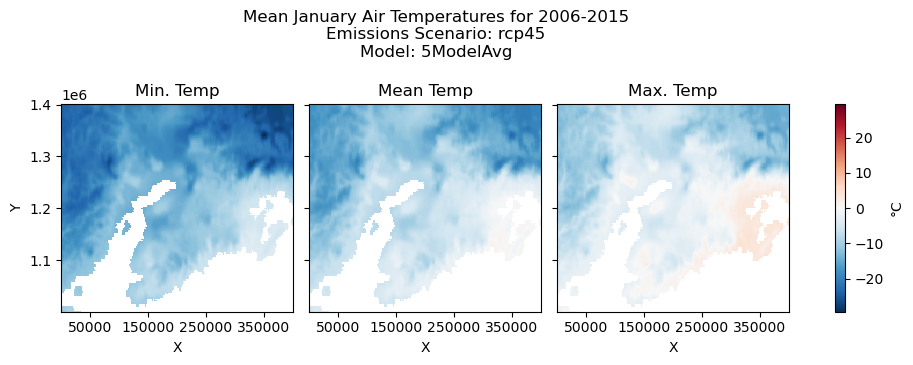

In [10]:
#the inputs below were from the original notebook
# month = int(input("Choose a month (1 to 12):"))
# model = input("Choose a model (5ModelAvg, GFDL-CM3, NCAR-CCSM4):")
# scenario = input("Choose a scenario (rcp45 or rcp85):")

#since we are using the mercury widget inputs, we extract values from those inputs here:
month = int(month_input.value)
model = model_input.value
scenario = scenario_input.value



# we want to take advantage of xarray's faceting capability
#  but in order to do so, we need to subset and restructure
#  the dataset such that the variable ID is a dimension.
# here is a new datacube with the decadal means for each variable for the given parameters:
var_ids = ["tasmin", "tas", "tasmax"]
data = np.array(
    [
        ds[var_id].sel(model=model, month=month, scenario=scenario).mean("year").values
        for var_id in var_ids
    ]
)
# we will borrow from the original dataset to construct a new one with spatial dimensions and a variable ID dimension
da = xr.DataArray(
    data=data,
    dims=["var_id", "Y", "X"],
    coords=dict(
        var_id=var_ids,
        Y=ds.Y,
        X=ds.X,
    ),
    attrs={"long_name": "°C"},
)
# now we can plot
g = da.plot(
    col="var_id",
    xticks=[5e4, 1.5e5, 2.5e5, 3.5e5],
)

# # set some titles
var_id_lu = {"tasmin": "Min. Temp", "tas": "Mean Temp", "tasmax": "Max. Temp"}
for var_id, ax in zip(var_ids, g.axs.flat):
    ax.set_title(f"{var_id_lu[var_id]}")

plt.suptitle(
    (
        f"Mean {calendar.month_name[month]} Air Temperatures for {ds.year.values.min()}-{ds.year.values.max()}"
        f"\nEmissions Scenario: {scenario}\nModel: {model}"
    ),
    x=0.45,
    y=1.2,
)
plt.show()

### Interactive plotting

Here is an example of constructing an interactive chart with the `hvplot` library and using some widgets from the `panel` library to control the displayed data:

In [11]:
var_select = pnw.Select(
    name="Variable", options={"tas": "tas", "tasmin": "tasmin", "tasmax": "tasmax"}
)

models_rbg = pnw.Select(
    name="Model", options={model: model for model in ds.model.values}
)
scenarios_rbg = pn.widgets.RadioButtonGroup(
    name="Scenario",
    options={scenario: scenario for scenario in ds.scenario.values},
    button_type="default",
)
month = pnw.Player(name="month", start=1, end=12, loop_policy="loop", interval=1000)

var_da = (
    ds.interactive()[var_select]
    .sel(model=models_rbg, scenario=scenarios_rbg, month=month)
    .mean(dim="year")
)
var_da.hvplot(cmap="coolwarm", kind="image", invert=True).opts(width=600, height=400)

BokehModel(combine_events=True, render_bundle={'docs_json': {'82a2dbe5-838e-43b1-8243-8cd2f602df60': {'version…

## A note on accessing large data

Many of the datasets hosted in SNAP's Rasdaman instance are rather large, and, as Rasdaman is optimized for subsetting and extraction operations, it is not as efficient for accessing entire datasets. If you are interested in accessing an entire dataset or large chunks of it, please consider finding it via our [our data portal](https://catalog.snap.uaf.edu/geonetwork) or contact us at uaf-snap-data-tools@alaska.edu for help.